In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic
from stack_segmentation.training import handle_stacks_data, make_model, train_loop
from stack_segmentation.unet import UNet
from stack_segmentation.pipeline_config import dataloaders_conf, model_conf, train_conf, loss_config

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:0'
model_conf['device'] = 'cuda:0'

In [8]:
data_conf['conf_name'] = 'basic_lr1e-2_epoch300_soft_aug'
data_conf

{'conf_name': 'basic_lr1e-2_epoch300_soft_aug',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
    slice(None, None, N

In [9]:
from stack_segmentation.aug_pipelines import soft_aug
dataloaders_conf['train']['augmentation_pipeline'] = soft_aug
dataloaders_conf

{'train': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': <function stack_segmentation.aug_pipelines.soft_aug(original_height=128, original_width=128, k=4)>},
 'val': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': False,
  'augmentation_pipeline': None},
 'test': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': None}}

In [10]:
train_conf['num_epochs'] = 300
train_conf

{'num_epochs': 300, 'device': 'cuda:0'}

In [11]:
model_conf['opt_type'] = 'SGD'
model_conf['lr'] = 1e-2
model_conf['weight'] = None
model_conf['nesterov'] = True
model_conf

{'device': 'cuda:0',
 'opt_type': 'SGD',
 'lr': 0.01,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False,
 'min_lr': 1e-06,
 'factor': 0.5,
 'patience': 5,
 'weight': None}

In [12]:
loss_config =[
    {'loss': 'BCE', 'weight': 1, 'params': {}},
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {}}]

In [13]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:03, 211.47it/s]
100%|██████████| 720/720 [00:07<00:00, 95.36it/s] 
8280it [00:00, 231221.91it/s]
7920it [00:00, 228416.83it/s]
700it [00:03, 217.18it/s]
100%|██████████| 700/700 [00:06<00:00, 100.65it/s]
8280it [00:00, 236877.43it/s]
7920it [00:00, 228452.96it/s]
710it [00:03, 208.07it/s]
100%|██████████| 710/710 [00:07<00:00, 99.83it/s] 
7920it [00:00, 236854.81it/s]
7560it [00:00, 226842.40it/s]
720it [00:00, 781.98it/s]
100%|██████████| 720/720 [00:07<00:00, 95.58it/s] 
8280it [00:00, 234461.03it/s]
720it [00:03, 224.47it/s]
100%|██████████| 720/720 [00:07<00:00, 97.45it/s] 
25920it [00:00, 114733.32it/s]
700it [00:03, 225.76it/s]
100%|██████████| 700/700 [00:06<00:00, 103.13it/s]
25200it [00:00, 106494.53it/s]
509it [00:01, 378.03it/s]
100%|██████████| 509/509 [00:02<00:00, 199.43it/s]
8144it [00:00, 225785.51it/s]
700it [00:03, 229.15it/s]
100%|██████████| 700/700 [00:06<00:00, 103.43it/s]
25200it [00:00, 196773.08it/s]
700it [00:00, 809.90it/s]
100%|██████████| 700/700 

In [19]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [20]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [21]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [22]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [23]:
device = 'cuda:0'

In [ ]:
model, criterion, optimizer, scheduler = make_model(loss_config=loss_config, **model_conf)

## Run experiment

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [17]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

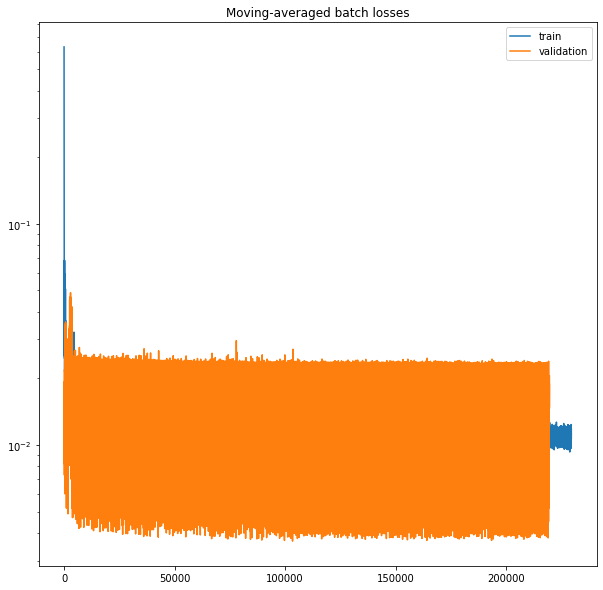

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

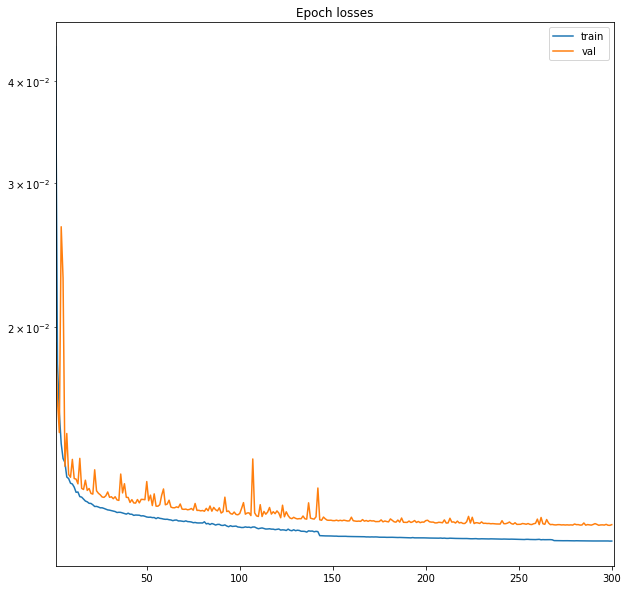

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996272,0.969973,0.987560,0.978688,0.998671,0.958265,carb96558,basic
1,0.989164,0.936295,0.981205,0.958224,0.995009,0.919798,carb71,basic
2,0.982574,0.983137,0.862284,0.918754,0.989157,0.849717,carbRNF,basic
3,0.991714,0.998258,0.910771,0.952510,0.998399,0.909326,SPE_carb10_58_box3,basic
4,0.987381,0.990032,0.890351,0.937550,0.993830,0.882441,SoilAh-1,basic
5,0.996651,0.978013,0.964011,0.970962,0.997511,0.943562,SoilB-2,basic
6,0.991692,0.996839,0.931973,0.963316,0.998380,0.929228,TeTree_subset1,basic
7,0.992470,0.996690,0.941788,0.968461,0.998851,0.938851,TiTree_subset2,basic
8,0.992839,0.974722,0.970069,0.972390,0.997648,0.946264,Urna_22,basic
9,0.990354,0.976243,0.967654,0.971930,0.997774,0.945392,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.92067
Std    IOU: 0.032395
Min    IOU: 0.84972
Median IOU: 0.92923
